In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

In [2]:
# PART 1(a) - Linear Separable Data
from cvxopt import matrix, solvers # Quadratic Programming solver

linsep = pd.read_csv('linsep.txt', header=None)
linsep.columns = ["x1", "x2", "label"]
X = linsep.drop('label', axis=1)
y = linsep['label']


In [3]:
def find_alphas(X, y, C):
    """
        Minimize
        1/2 * w^T w
        w.r.t.
        y_n (w^T x_n + b) >= 1
    
        Uses Lagrange multiplier to solve for alphas
        Parameters:
            X = data
            y = labels
            C = hardness of margin (will keep at 1e5 to match part 2 library)
        Return:
            alphas
            
        P:= H a matrix of size m×m
        q:= −1  a vector of size m×1
        G:= −diag[1] a diagonal matrix of -1s of size m×m
        h:= 0  a vector of zeros of size m×1
        A:= y the label vector of size m×1
        b:= 0 a scalar
            
     """
    m = X.shape[0]  # number of datapoints
    n = X.shape[1]  # number of features
    
    # H_n,m=y_n*y_m<X_n*X_m>
    H = y[:, None] * X
    # calculate Xn^T*Xm
    P = matrix(np.dot(H, H.T))

    q = matrix(-np.ones((m, 1)))

    G1 = -1 * np.eye(m)
    G2 = 1 * np.eye(m)
    h1 = np.zeros(m)
    h2 = np.zeros(m)
    h2.fill(C)

    G = matrix(np.concatenate((G1, G2), axis=0))
    h = np.concatenate((h1[:, None], h2[:, None]), axis=0)
    h = matrix(np.squeeze(h))
    
    # A = coefficients of the constraint equations (labels(y) in 1 x m dim)
    # b is single-col matrix, b = value on the right hand side of the constraint, therefore 0
    A = matrix(y.values.reshape(1, -1), (1,100), 'd')
    b = matrix(np.zeros(1))

    solvers.options['show_progress'] = False
    sol = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])

    return alphas


def get_weights_and_intercept(alphas, X, y):
    """
        w = Σ(alphas*y*X)
        
    """
    S=(alphas > 1e-4).flatten()
    w = np.sum(alphas * y[:, None] * X, axis=0)
    b = y[S] - np.dot(X[S], w)
    return w, np.array(b)[0]

def get_support_vectors(alphas,X):
    S=(alphas > 1e-4).flatten()
    return X[S]

In [4]:
alphas = find_alphas(X, y, 1e5)

In [5]:
w, b = get_weights_and_intercept(alphas, X, y)
print ("w =",np.array(w))
print("b =", b)

w = [ 7.25005631 -3.86188926]
b = -0.10698733678864691


In [6]:
support_vectors = get_support_vectors(alphas,X)
print('Support Vectors:\n', support_vectors)

Support Vectors:
           x1        x2
27  0.249794  0.182303
83  0.391789  0.966756
87  0.020665  0.270032


In [7]:
"""
hyperplane equation: 
wT * x +b = 0
OR
w · x + b = 0
"""

print('Hypothesis Equation/Decision Function: \n', 'g(x)=', np.array(w),'·', 'x +', b)

Hypothesis Equation/Decision Function: 
 g(x)= [ 7.25005631 -3.86188926] · x + -0.10698733678864691


In [8]:
## Part 1(b)

nonlinsep = pd.read_csv('nonlinsep.txt', header=None)
nonlinsep.columns = ["x1", "x2", "label"]
X_nls = nonlinsep.drop('label', axis=1)
y_nls = nonlinsep['label']

# The γ parameter sets the width of the bell-shaped curve. 
# The larger the value of γ the narrower will be the bell. Small values of γ yield wide bells.
# As the value of γ increases the model gets overfits. As the value of γ decreases the model underfits.
def gamma(X):
    gamma = 1 / (2 * X_nls.var())
    gamma = (gamma[0]+gamma[1])/2
    return gamma

In [9]:
def rbf_kernel(X, X_prime, gamma):
    K = np.zeros((X.shape[0], X_prime.shape[0]))
    for i, x in enumerate(np.array(X)):
        for j, x_prime in enumerate(np.array(X_prime)):
            K[i, j] = np.exp(-gamma * np.linalg.norm(x - x_prime) ** 2)
    return K

In [10]:
def rbf_alphas(X, y, C, gamma):
    
    m = X.shape[0]  # number of datapoints
    n = X.shape[1]  # number of features
    
    # H_n,m=y_n*y_m<X_n*X_m>
    H = y[:, None] * rbf_kernel(X, X, gamma)
    # calculate Xn^T*Xm
    P = matrix(np.dot(H, H.T))

    q = matrix(-np.ones((m, 1)))

    G1 = -1 * np.eye(m)
    G2 = 1 * np.eye(m)
    h1 = np.zeros(m)
    h2 = np.zeros(m)
    h2.fill(C)

    G = matrix(np.concatenate((G1, G2), axis=0))
    h = np.concatenate((h1[:, None], h2[:, None]), axis=0)
    h = matrix(np.squeeze(h))
    
    # A = coefficients of the constraint equations (labels(y) in 1 x m dim)
    # b is single-col matrix, b = value on the right hand side of the constraint, therefore 0
    A = matrix(y.values.reshape(1, -1), (1,100), 'd')
    b = matrix(np.zeros(1))

    solvers.options['show_progress'] = False
    sol = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])

    return alphas

In [11]:
nls_alphas = rbf_alphas(X_nls, y_nls, 1e5, gamma(X_nls))

In [12]:
w_nls, b_nls = get_weights_and_intercept(nls_alphas, X_nls, y_nls)
print ("w =",np.array(w_nls))
print("b =", b_nls)

w = [-21.94332854  -3.11296292]
b = -170.90166989011138


In [13]:
support_vectors = get_support_vectors(nls_alphas,X_nls)
print('Support Vectors:\n', support_vectors)

Support Vectors:
            x1         x2
5   -8.474228   5.156216
36 -10.260969   2.073918
51   1.339331 -10.290988
55   9.679177   4.375954
71  -9.467609   2.361395
94  -6.800023  -7.023843
95   9.901435  -0.314831


In [14]:
## Part 2(a) - linear-separable data

linsep = pd.read_csv('linsep.txt', header=None)
linsep.columns = ["x1", "x2", "label"]
X = linsep.drop('label', axis=1)
y = linsep['label']

In [15]:
# C represents HARDNESS of the margin!
# For very large C, the margin is hard, and points cannot lie in it. 
# For smaller C, the margin is softer, and can grow to encompass some points.
svc = SVC(kernel='linear', C=1e5)
svc.fit(X, y)

SVC(C=100000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [16]:
svc.support_vectors_

array([[0.3917889 , 0.96675591],
       [0.02066458, 0.27003158],
       [0.24979414, 0.18230306]])

In [17]:
b = svc.intercept_[0]
print("b =",b)

b = -0.10703977170718931


In [18]:
w = svc.coef_
wT = w.T
print('w =',w)
print("w^T =",wT)

w = [[ 7.24837069 -3.86099178]]
w^T = [[ 7.24837069]
 [-3.86099178]]


In [19]:
def plot_decision_func(X,y,svc):
    plt.scatter(np.array(X)[:, 0], np.array(X)[:, 1], c=y, s=30, cmap='spring')

    # plot the decision function
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = svc.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    # plot support vectors
    ax.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=100, linewidth=1, facecolors='none')
    plt.show()

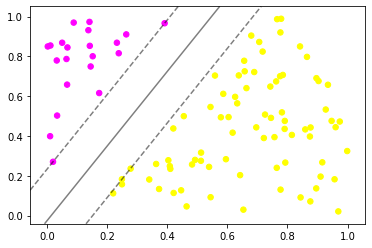

In [20]:
plot_decision_func(X,y,svc)

In [21]:
print('Hypothesis Equation/Decision Function: \n', 'g(x)=', wT, 'x +', b)

Hypothesis Equation/Decision Function: 
 g(x)= [[ 7.24837069]
 [-3.86099178]] x + -0.10703977170718931


In [22]:
# Part 2(b) - nonlinear-separable data with Quadratic Programming solver

nonlinsep = pd.read_csv('nonlinsep.txt', header=None)
nonlinsep.columns = ["x1", "x2", "label"]
X_nls = nonlinsep.drop('label', axis=1)
y_nls = nonlinsep['label']

In [23]:
svc_nls = SVC(kernel='rbf', C=1e5, gamma = 'scale')
svc_nls.fit(X_nls, y_nls)

SVC(C=100000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [24]:
svc_nls.support_vectors_

array([[ -9.53754332,  -0.51895777],
       [ -9.46760885,   2.36139525],
       [  9.90143538,  -0.31483149],
       [-10.260969  ,   2.07391791],
       [  1.66404809,  12.68562818],
       [  1.3393313 , -10.29098822],
       [  9.67917724,   4.3759541 ]])

In [25]:
b_nls = svc_nls.intercept_[0]
print("b =",b_nls)

b = 10.076815685489922


In [26]:
# dual_coef_ which holds the product alpha_n*y_i
# w = alpha_n*y_i
w_nls = svc_nls.dual_coef_
w_nls

array([[ -72.28213554, -468.33766756,  -25.00392674,  521.27739148,
           5.09538275,   15.97661348,   23.27434213]])

In [27]:
from ipywidgets import interact, fixed
from mpl_toolkits import mplot3d

r = np.exp(-(X ** 2).sum(1))

def plot_3D(elev=25, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(np.array(X)[:, 0], np.array(X)[:, 1], r, c=y, s=50, cmap='spring')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-25, 25], azip=(-180, 180),
         X=fixed(X_nls), y=fixed(y_nls));

interactive(children=(Dropdown(description='elev', index=1, options=(-25, 25), value=25), IntSlider(value=30, …

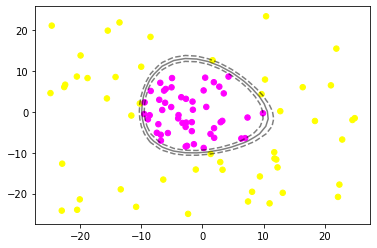

In [28]:
plot_decision_func(X_nls,y_nls,svc_nls)

In [29]:
print('Hypothesis Equation/Decision Function: \n', 'g(x)=', w_nls, 'K(x_n,x) +', b_nls, '\nwhere K(x_n,x) is the RBF kernel function used.')



Hypothesis Equation/Decision Function: 
 g(x)= [[ -72.28213554 -468.33766756  -25.00392674  521.27739148    5.09538275
    15.97661348   23.27434213]] K(x_n,x) + 10.076815685489922 
where K(x_n,x) is the RBF kernel function used.


In [30]:
# The γ parameter sets the width of the bell-shaped curve. 
# The larger the value of γ the narrower will be the bell. Small values of γ yield wide bells.
# As the value of γ increases the model gets overfits. As the value of γ decreases the model underfits.
gamma = 1 / (2 * X_nls.var())
gamma = (gamma[0]+gamma[1])/2
gamma

0.0038566248896485518